# K - Means clustering

K means es una tecnica de clasificacion **no supervisada** que busca agrupar un conjunto de datos en _K grupos_, donde K es un **hiperparametro** que se debe definir _antes de aplicar el algoritmo_. El objetivo del algoritmo es **minimizar la distancia** entre los puntos dentro de cada grupo y _maximizar la distancia entre los grupos_.

La tecnica de K means forma parte de las tecnicas de **clasificacion no parametrica**, ya que **no** requiere _suposiciones sobre la distribucion de los datos_, debido a ello _puede adaptarse mejor a estructuras de datos complejas_. Sin embargo, el algoritmo es sensible a la **inicializacion de los centroides**. Por lo tanto, es recomendable ejecutar el algoritmo varias veces con diferentes inicializaciones y elegir la mejor solucion.

---
## **Ruta de Implementación de un Modelo de k-means**

![pipeline](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*CKEc4j27kiRRJFJ-.jpg)

1. **Obtención de datos:** Para este ejemplo se utilizarán datos proporcionados por la librería sklearn, pero se recomienda la siguiente fuente:
   - [**Papers with Code**](https://paperswithcode.com/datasets): Esta página está enfocada en Inteligencia Artificial, debido a ello cuenta con una gran variedad de datos listos para su uso en el ámbito de la inteligencia artificial.
2. **Procesamiento de datos:** Entramos en el proceso de normalización, regularización, segmentación y saneado de datos, en caso de ser necesario.
3. **Entrenamiento del modelo:** Para este punto, se debe haber elegido un modelo acorde a nuestras necesidades dadas por experiencia e intuición para después implementarlo en el entorno requerido.
4. **Evaluación del modelo:** En este punto se evalúa el comportamiento del modelo, comprobando el comportamiento esperado.
5. **Puesta a producción:** Una vez que el modelo cumpla con los requisitos, se puede desplegar en su entorno de producción.
6. **Monitoreo y Mantenimiento:** Se revisita constantemente para evitar pérdidas o ser reentrenado de ser necesario.

_En este documento se enfocará en los puntos del 1 al 4._

---

### **Obtencion de datos**

In [2]:
# Como se menciono anteriormente usaremos los datos dados por sklearn para este tutorial. 
# Asi que comenzaremos con las importaciones necesarias.

import matplotlib.pyplot as plt  # Creacion de graficos
import pandas as pd  # Manipulacion de datos
import seaborn as sns  # Complemento de mejora en graficos
from sklearn.datasets import load_iris, load_wine, load_breast_cancer# Conjunto de datos

## _Procesamiento de datos_

---

### Visualizacion de datos

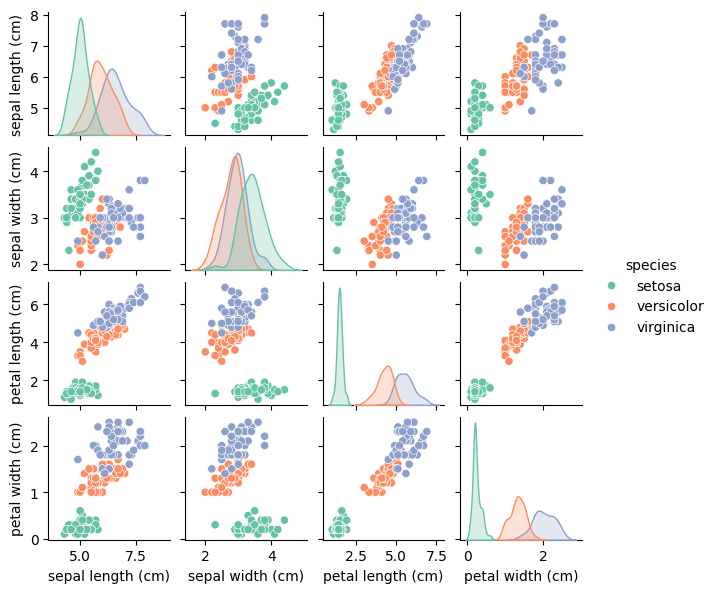

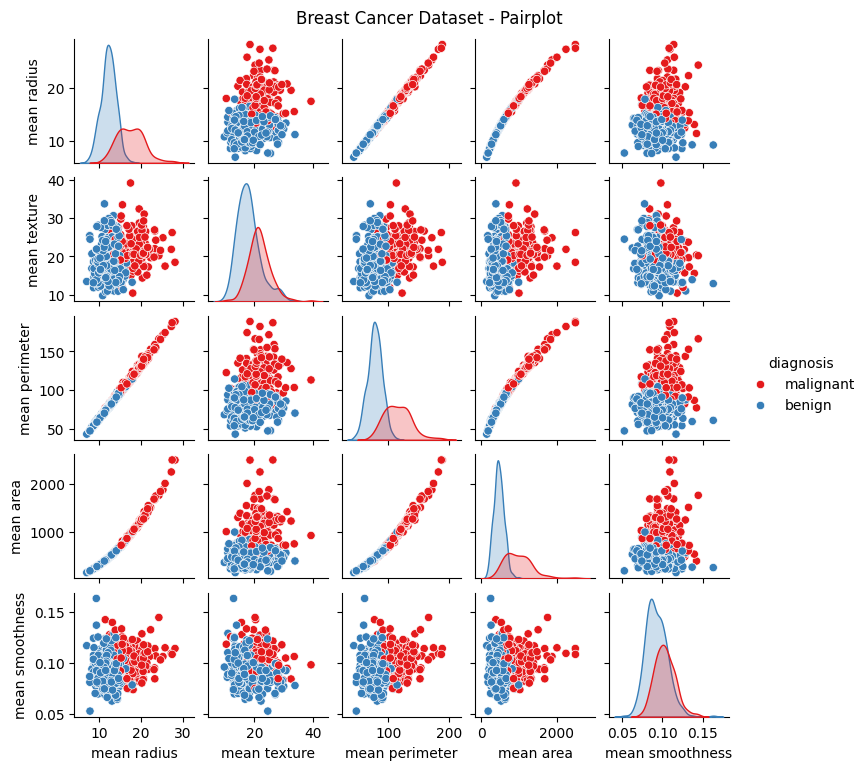

In [3]:
# Cargar datos
iris = load_iris()
X = iris.data
y = iris.target  # Etiquetas verdaderas (solo para comparación, no usadas en K-means)

# Convertir los datos en un DataFrame de pandas para visualizacion.
df = pd.DataFrame(data=X, columns=iris.feature_names)

# Añadir la columna de etiquetas de clase
df['species'] = iris.target_names[iris.target]

# 2. Matriz de dispersión (Pairplot) para visualizar relaciones entre todas las características
sns.pairplot(df, hue='species', palette='Set2',height=1.5)

# Mostrar el gráfico
plt.show()

# Cargar dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

df_cancer = pd.DataFrame(X_cancer, columns=cancer.feature_names)
df_cancer['diagnosis'] = ['malignant' if x == 0 else 'benign' for x in y_cancer]

# Elegimos solo algunas variables para visualizar (las más significativas)
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
df_plot = df_cancer[selected_features + ['diagnosis']]

# Pairplot
sns.pairplot(df_plot, hue='diagnosis', palette='Set1', height=1.5)
plt.suptitle("Breast Cancer Dataset - Pairplot", y=1.02)
plt.show()

### **Procesamiento de datos**

En el paso anterior se muestran dos gráficas: un _pairplot_ de los **datos de cáncer de mama** y otro de la **clasificación de plantas** de acuerdo a sus características de pétalo. En ellas podemos observar lo siguiente:

- _**Datos de iris**_:  
  Podemos notar, por las gráficas en la diagonal, que la variable _petal_length_ presenta un **sesgo muy marcado**. Por ello, es recomendable **normalizar** los datos, ya que esta variable podría influir de manera desproporcionada en el resultado final. Además, observamos que _sepal_width_ **no aporta información relevante para la clasificación**, por lo cual podría **eliminarse** del análisis.

- _**Datos de cáncer de mama**_:  
  Podemos observar que el **tamaño de la muestra es considerable**, por lo cual se **recortaron las muestras en la visualización** para facilitar su interpretación. En las gráficas, se nota que _mean_radius_ y _mean_perimeter_ están **fuertemente correlacionadas**, siguiendo una **relación lineal**. Por esta razón, se puede **eliminar la variable mean_perimeter**, ya que **no aporta información adicional**. Asimismo, _mean_area_ y _mean_radius_ presentan un comportamiento similar, por lo que también podría **eliminarse mean_area**.  
  En este caso, las variables que **más aportan a la clasificación** son:

  - _mean_radius_
  - _mean_texture_
  - _mean_smoothness_

  Por lo tanto, **se podría continuar el análisis utilizando solo estas tres variables**.

---

Para este ejemplo, se utilizarán los datos de **iris**, por ello se procederá a la **normalización de los datos**.


In [4]:
from sklearn.preprocessing import StandardScaler  # Importa la clase para estandarización de datos

scaler = StandardScaler()  # Crea una instancia del scaler.

X_scaled = scaler.fit_transform(X)  # Normaliza los datos para que tengan media 0 y desviación estándar 1, reduciendo el sesgo.

# X_scaled = scaler.fit_transform(X_cancer)  # Normaliza los datos de cáncer de mama → Para cambiar al dataset de cáncer de mama, descomenta esta línea y comenta la anterior

## _**Planteamiento del modelo**_

### Ya que decidimos usar el algoritmo de _**K-means**_, debemos construir el modelo.

1.  **Formalización del problema:**

    El objetivo de _**K-means**_ es encontrar _**K centroides**_ (c₁, c₂, ..., cₖ) que minimicen la _**suma de las distancias cuadradas**_ entre los puntos y sus respectivos centroides.

    > **¿Qué representa geométricamente un centroide?**:  
    > Cada _**centroide**_ representa el _**centro de masa**_ de los puntos asignados a ese _**clúster**_; geométricamente, es el _**promedio ponderado euclideano**_.

    La función objetivo a minimizar es:

    $J(C) = ∑_{j=1}^K ∑_{xᵢ ∈ Cⱼ} ||xᵢ - cⱼ||²$

    donde _**Cⱼ**_ es el conjunto de puntos asignados al _**clúster j**_.  
    La función objetivo _**J(C)**_ mide la _**calidad de la partición**_ de los datos en _**K clústeres**_.  
    El algoritmo _**K-means**_ busca _**minimizar esta función objetivo**_ iterativamente.

2.  **Algoritmo K-means:**

    El algoritmo _**K-means**_ sigue los siguientes pasos:

    1.  _**Inicializar**_ K _**centroides aleatoriamente**_.
    2.  _**Asignar cada punto**_ al clúster cuyo centroide esté más cercano.
        - Esto tiene la forma:  
          $J_1 = ∑_{xᵢ ∈ C_1} ||xᵢ - c_1^{(0)}||²$
        - Donde $c_1^{(0)}$ es el _**centroide inicial**_ del clúster 1.
    3.  _**Actualizar los centroides**_ como el _**promedio**_ de los puntos asignados a cada clúster.
    4.  Repetir los pasos 2 y 3 hasta que los centroides no cambien significativamente.
    5.  Devolver los _**centroides finales**_ y las _**asignaciones de clústeres**_.

        - El algoritmo se detiene devolviendo los valores de los _**centroides**_ y la _**asignación de clústeres**_.
        - La convergencia se puede verificar mediante la **_Varianza Intra-Cluster_** (_**WCSS**_), que mide la _**variabilidad dentro de cada clúster**_.
        - La varianza intra-cluster se define como:  
          $WCSS = \frac{1}{C_i} ∑_{xᵢ ∈ Cⱼ} ||xᵢ - cⱼ||²$
          - Esto se interpreta como _**qué tan compactos**_ se encuentran los puntos dentro de cada clúster.
        - Otro método de convergencia es observar el _**costo de la función objetivo**_.  
          Si el costo no disminuye significativamente, se puede considerar que el algoritmo ha _**convergido**_.

          > **Nota:** El valor de _**J**_ mide la _**inercia intra-clúster**_, es decir, _**qué tan compactos**_ son los grupos formados.

          - La asignación de clústeres y actualización de centroides _**nunca incrementa**_ el valor de _**J**_.
          - El descenso de _**J**_ se hace más lento con cada paso: se aproxima a un _**mínimo local**_.
          - El algoritmo termina cuando los _**centroides dejan de cambiar**_ o _**J se estabiliza**_.

    6.  _**Ajustar el número de clústeres K**_ si es necesario y repetir el proceso.

    - **Parámetros del algoritmo:**
      - **K:** _Número de clústeres_ a formar.
      - **Max_iter:** _Número máximo de iteraciones_.
      - **Tol:** _Tolerancia para la convergencia_. Si la diferencia entre centroides consecutivos es menor, el algoritmo se detiene.
      - **Init:** Método de _**inicialización de centroides**_. Puede ser `"k-means++"` (recomendado) o `"random"`.
      - **N_init:** _Número de inicializaciones distintas_. Se elige el resultado con la mejor _**inercia**_.

3.  **Elección del número de clústeres K:**

    La elección del número de _**clústeres K**_ es un paso _**crítico**_ en el algoritmo _**K-means**_.  
    Existen varios métodos para determinar el valor óptimo de K, como:

    - el _**método del codo**_,
    - el _**método de la silueta**_, y
    - el _**análisis jerárquico**_.

    En este caso, se utilizará el _**método del codo**_.

    - **Método del codo:**  
      Este método consiste en calcular la _**suma de las distancias cuadradas**_ para diferentes valores de K y graficar los resultados.  
      El punto donde la disminución de esta suma se vuelve menos pronunciada (el "_**codo**_") indica un buen valor para K.

      > **En la gráfica del método del codo**, se observa que a medida que aumenta _**el número de clústeres**_, la _**inercia disminuye**_.  
      > Sin embargo, después de cierto punto, la disminución de la inercia _**se vuelve menos pronunciada**_.  
      > Este punto es el _**"codo"**_ y se considera un buen valor para **K**.

---

Pasemos a el ajuste con la ayuda de la librería `sklearn`.


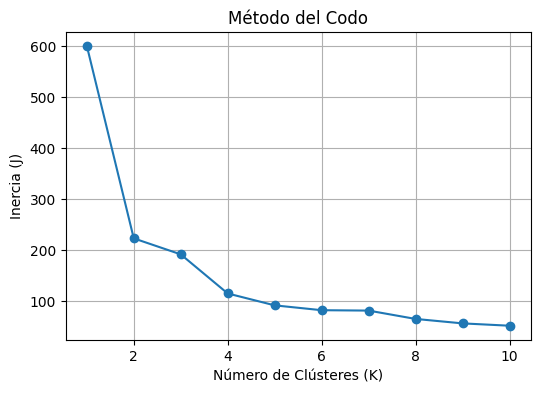

In [5]:
from sklearn.cluster import KMeans  # Importa el algoritmo KMeans

# Método del codo: probar diferentes valores de K y graficar la inercia
inertias = []
k_range = range(1, 11) # Numero de clústeres a probar (1 a 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Inercia (J)")
plt.title("Método del Codo")
plt.grid(True)
plt.show()

## **Analisis del metodo del codo**

Con el análisis realizado mediante el **método del codo**, se determinó que el **número óptimo de clústeres** se encuentra entre **2 y 4**, ya que la función de inercia (**J**) comienza a estabilizarse en ese rango. A partir de ese punto, las mejoras al agregar más clústeres son **mínimas**, lo que indica una **pérdida de eficiencia** al aumentar K sin un beneficio claro.
\
Adicionalmente, para validar la calidad de los clústeres generados, se utilizará el **Silhouette Score**, el cual proporciona una medida de qué tan bien separados están los clústeres y qué tan cohesivos son internamente.
\
Si este valor se encuentra en un rango **aceptable y sólido**, sugiere que los clústeres generados son **bien definidos**, con una separación razonable entre grupos. El marco de referencia es:

- Un valor **mayor a 0.7** se considera **excelente**.
- Un valor entre **0.5 y 0.7** indica un **buen agrupamiento**.
- Un valor cercano a **0 o negativo** implica **asignaciones incorrectas**.

### **Funcionamiento del Silhouette Score**

Dado un punto ( i ), el puntaje de silueta se calcula como:

$$
s\left( i \right) = \frac{b\left( i \right) - a\left( i \right)}{\max\left\{ a\left( i \right),\ b\left( i \right) \right\}} \\
\\
$$

donde:

$\left( a\left( i \right) \right)$ es la distancia media del punto $\left( i \right)$ a todos los otros puntos en su mismo clúster (cohesión).
\
$\left( b\left( i \right) \right)$ es la distancia media del punto $\left( i \right)$ al clúster más cercano al que no pertenece (separación).

El valor de $\left( s\left( i \right) \right)$ estará en el rango de $\left( -1 \right)$ a $\left( 1 \right)$, y el **Silhouette Score global** es el promedio de todos los $\left( s\left( i \right) \right)$.


Silhouette Score del modelo: 0.5818


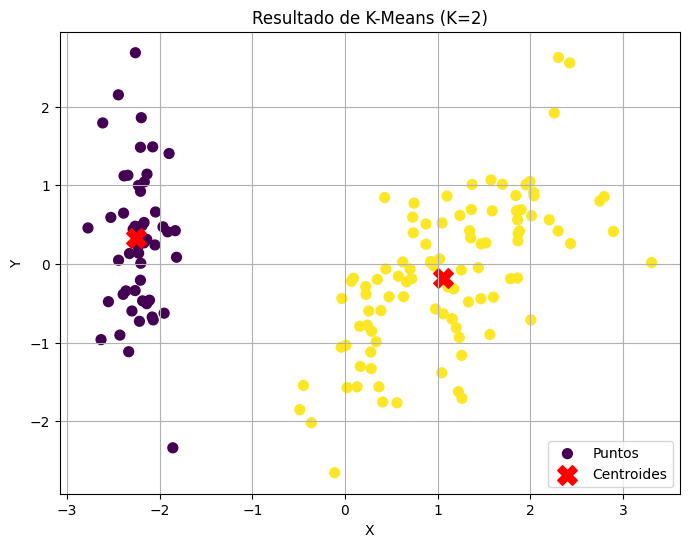

In [8]:
from sklearn.model_selection import (
    train_test_split,
)  # Importa la función para dividir los datos
from sklearn.metrics import silhouette_score  # Importa la métrica de Silhouette
from sklearn.decomposition import PCA  # Importa PCA para reducción de dimensionalidad

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Inicializamos el modelo KMeans con K=2
kmeans = KMeans(n_clusters=2, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
kmeans.fit(X_train)

# Predicción sobre el conjunto de prueba
y_pred = kmeans.predict(X_scaled)
sil_score = silhouette_score(X_scaled, y_pred)

print(f"Silhouette Score del modelo: {sil_score:.4f}")

# Visualización de los clústeres en 2D (usando pca)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(
    X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap="viridis", s=50, label="Puntos"
)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="red",
    marker="X",
    s=200,
    label="Centroides",
)
plt.title("Resultado de K-Means (K=2)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

## Conclusión

Con estos resultados, se concluye que el modelo entrenado mediante **K-Means** con 2 clústeres ofrece un agrupamiento de calidad aceptable, y puede ser considerado para su **fase de despliegue y monitoreo**.